In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv("Modified_SQL_Dataset.csv")

In [3]:
data.dropna(inplace=True)
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [4]:

from tqdm import tqdm
preprocessed_query = []
lemmatizer = WordNetLemmatizer()
# tqdm để hiển thị thanh trạng thái
for sentance in tqdm(data['Query'].values):
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    sentance = re.sub(r',', ' ', sentance)
    #https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    tokenization = nltk.word_tokenize(sentance)
    sentance = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_query.append(sentance.strip())

100%|██████████| 30919/30919 [00:04<00:00, 6558.52it/s] 


In [5]:
preprocessed_query

['pg sleep time',
 'create user name identified pass123 temporary tablespace temp default tablespace user',
 '1 utl inaddr get host address select distinct table name select distinct table name rownum limit sys table limit 5',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 1 union select 1 version 1',
 'select name syscolumns id select id sysobjects name tablename',
 'select user id 1 1 1 1',
 '1 load file char 47 101 116 99 47 112 97 115 115 119 100 1 1 1',
 'select user id 1 1 1 union select 1 version 1',
 'select user id 1 union select 1 version 1',
 '1 1',
 '',
 'admin 1 1',
 'select user id 1 1 1 1',
 '1 1',
 '1 utl inaddr get host address select distinct column name select distinct column name rownum limit tab column limit 5',
 'select user id 1 union select 1 version 1',
 'select user id 1 1 1 1',
 'select user id 1 1 1 1',
 'distinct',
 'select user id 1 1 1 1',
 '1 ascii lower substring select top 1 name sysobjects xtype u 1 1 116',
 'select user id 1 1 1

In [6]:
data['Query'] = preprocessed_query
data.head()

,Query,Label
0,pg sleep time,1
1,create user name identified pass123 temporary ...,1
2,1 utl inaddr get host address select distinct ...,1
3,select user id 1 1 1 union select 1 version 1,1
4,select user id 1 1 union select 1 version 1,1


In [7]:
# Chuyển đổi thành Bag of Words (BoW)
count_vect = CountVectorizer(ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform(preprocessed_query)

# Lấy tên các đặc trưng
feature_names = count_vect.get_feature_names_out()
print(f"Feature names (first 10): {feature_names[:10]}")
print(f"Shape of the feature matrix: {X_train_counts.shape}")



Feature names (first 10): ['00' '000001' '000003' '000004' '000023' '000045' '00033926r' '00041731d'
 '00207473j' '00217e']
Shape of the feature matrix: (30919, 24462)


In [8]:

X = X_train_counts
y = data['Label']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (24735, 24462)
X_test shape: (6184, 24462)
y_train shape: (24735,)
y_test shape: (6184,)


<h3> Áp dụng SVM </h3>

In [10]:
pip install tensorflow-gpu


Note: you may need to restart the kernel to use updated packages.Collecting tensorflow-gpu
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'



  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\DELL\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\DELL\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\DELL\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\D

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the SVM model and hyperparameter grid
svm_parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm = SVC()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=svm, param_grid=svm_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Score: 0.9573074590661006
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3893
           1       0.99      0.90      0.94      2291

    accuracy                           0.96      6184
   macro avg       0.97      0.95      0.96      6184
weighted avg       0.96      0.96      0.96      6184



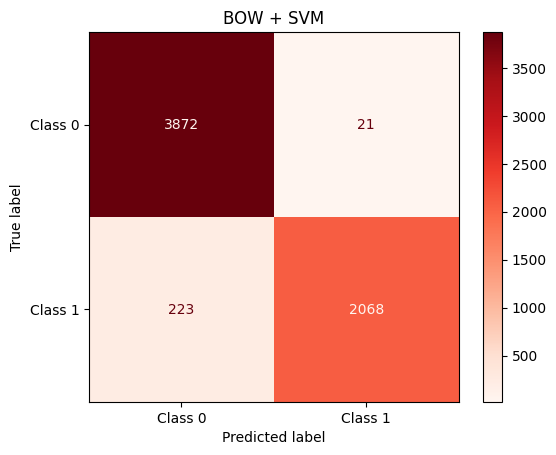

In [15]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_svm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BOW + SVM')
plt.show()


<h3> Áp dụng NB </h3>

In [12]:
from sklearn.naive_bayes import MultinomialNB

# Define the NB model and hyperparameter grid
nb_parameters = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}
nb = MultinomialNB()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=nb, param_grid=nb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.951809177279159
Best Parameters: {'alpha': 0.01, 'fit_prior': False}


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3893
           1       0.97      0.92      0.94      2291

    accuracy                           0.96      6184
   macro avg       0.96      0.95      0.95      6184
weighted avg       0.96      0.96      0.96      6184



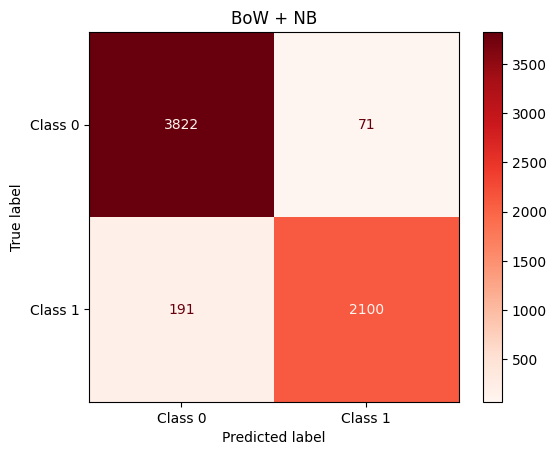

In [13]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_nb = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nb, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + NB')
plt.show()


<h3> Áp dụng KNN </h3>

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN model and hyperparameter grid
knn_parameters = {'n_neighbors': [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
knn = KNeighborsClassifier()

# Set up GridSearchCV with 5-fold cross-validation
grid = GridSearchCV(estimator=knn, param_grid=knn_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

# Output the best score and parameters
print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 5 folds for each of 26 candidates, totalling 130 fits
Best Score: 0.7332929047907824
Best Parameters: {'n_neighbors': 1}


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      3893
           1       0.59      0.96      0.73      2291

    accuracy                           0.74      6184
   macro avg       0.78      0.78      0.74      6184
weighted avg       0.82      0.74      0.74      6184



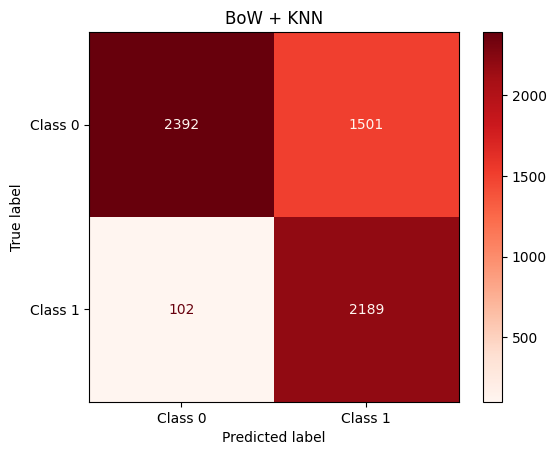

In [28]:
# Make predictions on the test set
y_pred = grid.predict(X_test)

# Confusion matrix and classification report
conf_matrix_knn = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + KNN')
plt.show()


<h3> Áp dụng RF </h3>

In [20]:

from sklearn.ensemble import RandomForestClassifier
rf_parameters = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [10, 20, 30, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=rf_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Score: 0.9252071962805741
Best Parameters: {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [21]:

y_pred = grid.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3893
           1       1.00      0.72      0.84      2291

    accuracy                           0.90      6184
   macro avg       0.93      0.86      0.88      6184
weighted avg       0.91      0.90      0.89      6184



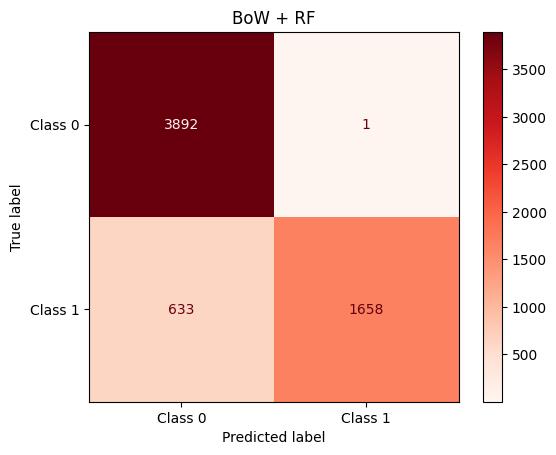

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + RF')
plt.show()

<h3> Áp dụng AdaBoost </h3>

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
#Weak Learner
base = DecisionTreeClassifier(max_depth=1)
#Ensemble learning
ada = AdaBoostClassifier(estimator=base)

grid = GridSearchCV(estimator=ada, param_grid=ada_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score: 0.931999191429149
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}


In [15]:
y_pred = grid.predict(X_test)
conf_matrix_ada = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3893
           1       0.97      0.85      0.91      2291

    accuracy                           0.94      6184
   macro avg       0.94      0.92      0.93      6184
weighted avg       0.94      0.94      0.93      6184



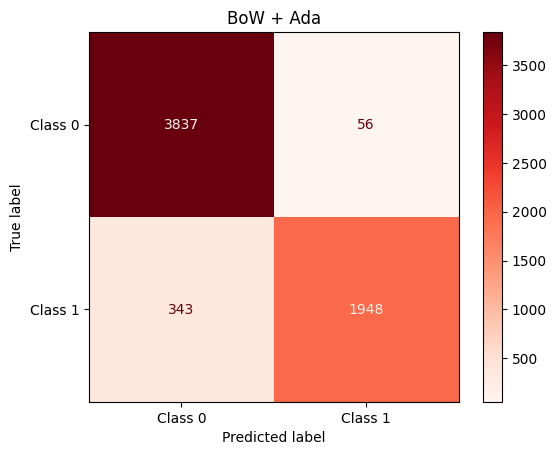

In [16]:

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ada, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + Ada')
plt.show()

<h3> Áp dụng XGBoost </h3>

In [17]:

from xgboost import XGBClassifier

xgb_parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(estimator=xgb, param_grid=xgb_parameters, scoring='accuracy', verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Score: " + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Best Score: 0.9387507580351728
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [18]:
y_pred = grid.predict(X_test)
conf_matrix_xgb = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      3893
           1       0.98      0.86      0.92      2291

    accuracy                           0.94      6184
   macro avg       0.95      0.93      0.94      6184
weighted avg       0.94      0.94      0.94      6184



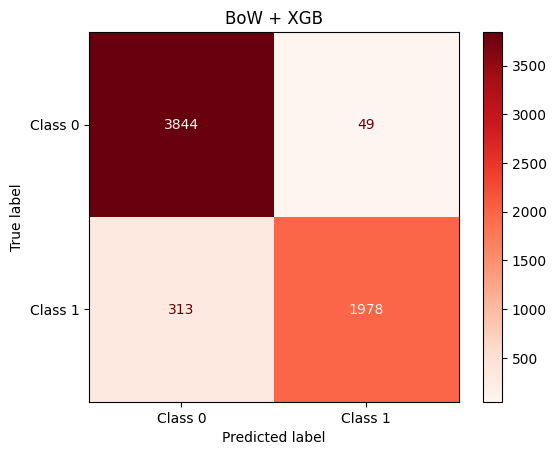

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Reds')
plt.title('BoW + XGB')
plt.show()
